In [1]:
import os
import pickle

import pandas as pd
import numpy as np

from collections import OrderedDict     

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Collected data

In [4]:
%env MLPERF_HPC_ROOT=/home/lukasd/src/mlperf

%env MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP=data_benchmark/2020-08-05_00-21-54_daint101/

env: MLPERF_HPC_ROOT=/home/lukasd/src/mlperf
env: MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP=data_benchmark/2020-08-05_00-21-54_daint101/


In [5]:
%%bash

echo "## Data benchmark experiments ##"
set -x
tree ${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}
set +x

## Data benchmark experiments ##
/home/lukasd/src/mlperf/cosmoflow-benchmark/results/data_benchmark/2020-08-05_00-21-54_daint101/
├── gpu-n1
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n1024
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n128
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n16
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n2
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n256
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n32
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n4
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n512
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n64
│   ├── config.pkl
│   └── data_benchmark_history.csv
├── gpu-n8
│   ├── config.pkl
│   └── data_benchmark_history.csv
└── logs
    ├── train-cosmoflow-daint-24773479.out
    ├── train-cosmoflow-daint-24773480.out
    ├── train-cosmoflow-daint-24773481.out
    ├

+ tree /home/lukasd/src/mlperf/cosmoflow-benchmark/results/data_benchmark/2020-08-05_00-21-54_daint101/
+ set +x


In [6]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'data_benchmark_history.csv')
    history = pd.read_csv(history_file)
    for col in ['local_times', 'global_times']:
        history[col] = history[col].apply(lambda x: np.fromstring(x.strip('[]'), dtype=float, sep=' '))
    return history

def get_num_samples(config, ranks):
    dconf = config['data']
    n = dconf['n_train'] + dconf['n_valid']
    if not dconf['shard']:
        n *= ranks
    return n


### Data from a single data benchmark run

In [7]:
result_dir = os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}/gpu-n%i') % 2
load_config(result_dir)

{'output_dir': 'results/data_benchmark/2020-08-05_00-21-54_daint101/gpu-n2',
 'data': {'name': 'cosmo',
  'data_dir': '/scratch/snx3000/lukasd/mlperf/data/cosmoflow/cosmoUniverse_2019_05_4parE_tf',
  'n_train': 512,
  'n_valid': 128,
  'sample_shape': [128, 128, 128, 4],
  'batch_size': 4,
  'n_epochs': 5,
  'shard': True,
  'apply_log': True,
  'prefetch': 4},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 4],
  'target_size': 4,
  'conv_size': 32,
  'fc1_size': 128,
  'fc2_size': 64,
  'hidden_activation': 'LeakyReLU',
  'pooling_type': 'MaxPool3D',
  'dropout': 0.5},
 'optimizer': {'name': 'SGD', 'momentum': 0.9},
 'lr_schedule': {'base_lr': 0.001,
  'scaling': 'linear',
  'base_batch_size': 64,
  'n_warmup_epochs': 4,
  'decay_schedule': {32: 0.25, 64: 0.125}},
 'train': {'loss': 'mse', 'metrics': ['mae'], 'early_stopping_patience': 8},
 'device': {'inter_threads': 0, 'intra_threads': 0},
 'n_ranks': 2}

In [8]:
load_result(result_dir)

,Unnamed: 0,epoch,local_times,global_times
0,0,0,"[156.45093, 150.45677]","[156.47194, 156.51492]"
1,1,1,"[6.238575, 6.2450433]","[6.2702446, 6.271353]"
2,2,2,"[6.3284893, 6.362862]","[6.382362, 6.3806553]"
3,3,3,"[7.4706745, 7.60186]","[7.6232605, 7.6234684]"
4,4,4,"[6.2428102, 6.2542]","[6.2680063, 6.268879]"


## Evaluation utilities

In [9]:
# The following functions filter config records for relevant entries 
# (rewrite them to analyze performance over different config variables)
def get_rank_samples(ranks, config):
    return OrderedDict(ranks=ranks,
                       samples=get_num_samples(config, ranks))    


def get_rank_samples_device_props(ranks, config):
    return OrderedDict(ranks=ranks,
                       samples=get_num_samples(config, ranks),
                       **config['device'])    


# compute per-run performance metrics on selection of epochs
def compute_epoch_selection_summary(config_param, benchmark_history):
    if isinstance(benchmark_history, pd.Series):
        local_times = benchmark_history['local_times']
        global_times = benchmark_history['global_times']
    else:
        local_times = np.vstack(benchmark_history['local_times'].to_numpy())
        global_times = np.vstack(benchmark_history['global_times'].to_numpy())

    n_ranks =  config_param['ranks']
    n_samples = config_param['samples']
    
    local_throughputs = n_samples / (n_ranks*local_times)
    global_throughputs = n_samples / global_times

    return dict(total_time_mean=np.mean(global_times),
                total_time_std=np.std(global_times),
                local_throughput_mean=np.mean(local_throughputs),
                local_throughput_std=np.std(local_throughputs),
                total_throughput_mean=np.mean(global_throughputs),
                total_throughput_std=np.std(global_throughputs))

# compute per-run performance metrics
def compute_data_benchmark_summary(config_param, benchmark_history):

    initial_epoch_stats = compute_epoch_selection_summary(config_param, 
                                                          benchmark_history.loc[0])
    if benchmark_history.shape[0] > 1:
        later_epoch_stats = compute_epoch_selection_summary(config_param,
                                                            benchmark_history[benchmark_history['epoch'] > 0])
    else:
        later_epoch_stats = {}
    return initial_epoch_stats, later_epoch_stats
    
    
# Compute ideal vs. effective weak scaling relative to single node
def compute_scaling(stats):
    stats['local_ideal'] = stats.ranks.apply(lambda r: 1.) * stats['local_throughput_mean'].loc[0]
    stats['local_eff']   = stats.apply(lambda result: result['local_throughput_mean']/result['local_ideal'], axis=1)

    stats['total_ideal'] = stats.ranks * stats['total_throughput_mean'].loc[0]
    stats['total_eff']   = stats.apply(lambda result: result['total_throughput_mean']/result['total_ideal'], axis=1)    

    return stats
    


def get_experimental_results(paths, ranks, extract_config_params, extract_results, compute_extra_metrics=None):
    """
    Loops over ranks-paths-pairs and computes throughput metrics.
    Configuration parameters and results to keep can be specified with `extract_config_params`, `extract_results`.
    Extra metrics on first and higher epochs can be added to DataFrames in `compute_extra_metrics`.
    Returns results in a dataframe.
    """    
    configs, results = [], []
    for (path,r) in zip(paths,ranks):
        result_dir = path
        configs.append(load_config(result_dir))
        results.append(load_result(result_dir))

    config_params = [extract_config_params(r,c) for (r,c) in zip(ranks, configs)]

    for config in config_params:
        if config.keys() != config_params[0].keys():
            raise RuntimeError('Extracted config keys must be the same for all experiments.')
    config_keys = list(config_params[0].keys())
            
    init_summaries, later_summaries = \
        zip(*[compute_data_benchmark_summary(conf,res) for (conf,res) in zip(config_params, results)])

    results = [extract_results(r) for r in results]
    
    # Merge config and summary (result for double checking)
    init_stats  = pd.DataFrame.from_records([{**conf, **res, **summ} for (conf, res, summ) in zip(config_params, results, init_summaries )])
    later_stats = pd.DataFrame.from_records([{**conf, **res, **summ} for (conf, res, summ) in zip(config_params, results, later_summaries)])
    
    if compute_extra_metrics is not None:
        init_stats  = compute_extra_metrics(init_stats)
        later_stats = compute_extra_metrics(later_stats)
    
#     stats = init_stats.merge(later_stats, on=['ranks','samples'], suffixes=('_init','_later'))
    stats = init_stats.merge(later_stats, on=config_keys, suffixes=('_init','_later'))

    return stats

# Ignore results (except for computed throughput metrics)
def discard_results(result):
    return {}

# Standard weak scaling metrics
def get_scaling_results(path_pattern, ranks):
    paths = [path_pattern % r for r in ranks]
    return get_experimental_results(paths, ranks, get_rank_samples, discard_results, compute_scaling)

# Extract device config parameters in addition to above metrics
def get_device_prop_results(paths, ranks):
    return get_experimental_results(paths, ranks, get_rank_samples_device_props, discard_results)


# Data loading benchmark

Weak scaling of data loading with 256 training samples & 64 validation samples per rank (one rank per node), up to 1024 nodes. 

In [10]:
results = get_scaling_results(
    os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_TIMESTAMP}/gpu-n%i'),
    ranks=np.array([2**i for i in range(11)]))
results

/home/lukasd/src/mlperf/cosmoflow-benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # Remove the CWD from sys.path while we load stuff.


,ranks,samples,total_time_mean_init,total_time_std_init,local_throughput_mean_init,local_throughput_std_init,total_throughput_mean_init,total_throughput_std_init,local_ideal_init,local_eff_init,...,total_time_mean_later,total_time_std_later,local_throughput_mean_later,local_throughput_std_later,total_throughput_mean_later,total_throughput_std_later,local_ideal_later,local_eff_later,total_ideal_later,total_eff_later
0,1,320,150.264190,0.000000,2.129839,0.000000,2.129583,0.000000,2.129839,1.000000,...,6.489354,0.093451,49.457012,0.735149,49.321757,0.710061,49.457012,1.000000,49.321757,1.000000
1,2,640,156.493430,0.021490,2.086113,0.040744,4.089629,0.000562,2.129839,0.979470,...,6.636029,0.571867,48.843115,3.702922,97.100322,7.626039,49.457012,0.987587,98.643514,0.984356
2,4,1280,155.193880,0.015078,2.107255,0.026458,8.247748,0.000801,2.129839,0.989397,...,6.748138,0.358678,48.190793,2.687641,190.202862,9.806119,49.457012,0.974398,197.287029,0.964092
3,8,2560,165.271197,0.004527,1.994264,0.044341,15.489692,0.000424,2.129839,0.936345,...,6.699254,0.353126,48.714375,2.519231,383.164267,19.596192,49.457012,0.984984,394.574057,0.971083
4,16,5120,157.643154,0.028613,2.091437,0.042243,32.478418,0.005894,2.129839,0.981970,...,6.774516,0.488878,48.661178,3.193425,759.542714,52.280062,49.457012,0.983909,789.148114,0.962484
5,32,10240,161.947900,0.016110,2.064188,0.035965,63.230212,0.006290,2.129839,0.969175,...,6.788149,0.556051,48.784130,3.898683,1517.827747,113.741941,49.457012,0.986395,1578.296229,0.961687
6,64,20480,171.434045,0.012794,1.955745,0.041394,119.462853,0.008915,2.129839,0.918259,...,6.714009,0.361780,49.503954,2.533187,3058.711587,155.401678,49.457012,1.000949,3156.592457,0.968992
7,128,40960,152.289881,0.006223,2.276600,0.062761,268.960747,0.010991,2.129839,1.068907,...,7.452257,0.637235,45.916462,4.587500,5537.397193,480.924562,49.457012,0.928412,6313.184914,0.877116
8,256,81920,140.856504,0.011522,2.395878,0.049306,581.584792,0.047569,2.129839,1.124910,...,7.462975,0.612629,46.930513,4.458784,11046.338560,847.470283,49.457012,0.948915,12626.369828,0.874863
9,512,163840,105.033669,0.015995,3.324505,0.102437,1559.880803,0.237518,2.129839,1.560918,...,8.667767,0.516433,41.896833,3.250614,18971.588413,1165.982731,49.457012,0.847136,25252.739657,0.751269


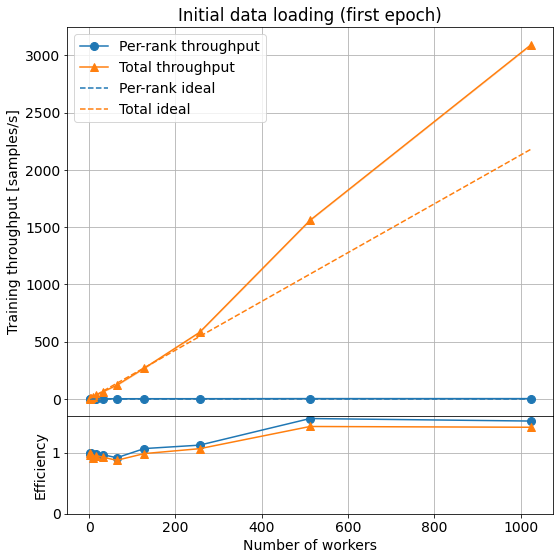

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Initial data loading (first epoch)')
ax0.plot(results.ranks, results.local_throughput_mean_init, 'o-',  ms=8, label='Per-rank throughput', color='tab:blue')
ax0.fill_between(results.ranks, results.local_throughput_mean_init - results.local_throughput_std_init, results.local_throughput_mean_init + results.local_throughput_std_init, alpha=0.2, color='tab:blue')
ax0.plot(results.ranks, results.total_throughput_mean_init, '^-', ms=8, label='Total throughput', color='tab:orange')
ax0.fill_between(results.ranks, results.total_throughput_mean_init - results.total_throughput_std_init, results.total_throughput_mean_init + results.total_throughput_std_init, alpha=0.2, color='tab:orange')
ax0.plot(results.ranks, results.local_ideal_init, '--',  label='Per-rank ideal', color='tab:blue')
ax0.plot(results.ranks, results.total_ideal_init, '--', label='Total ideal', color='tab:orange')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.local_eff_init, 'o-', ms=8, color='tab:blue')
ax1.plot(results.ranks, results.total_eff_init, '^-', ms=8, color='tab:orange')
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.)
ax1.grid()

plt.tight_layout()

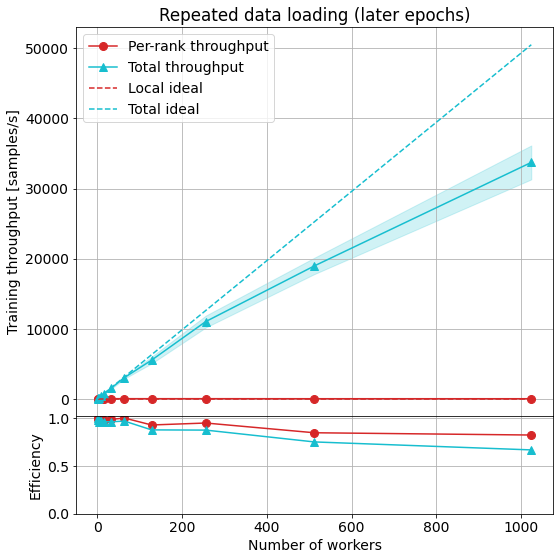

In [12]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8,8),
                               gridspec_kw=dict(height_ratios=[.8, .2], hspace=0))

ax0.set_title('Repeated data loading (later epochs)')
ax0.plot(results.ranks, results.local_throughput_mean_later, 'o-',  ms=8, label='Per-rank throughput', color='tab:red')
ax0.fill_between(results.ranks, results.local_throughput_mean_later - results.local_throughput_std_later, results.local_throughput_mean_later + results.local_throughput_std_later, alpha=0.2, color='tab:red')
ax0.plot(results.ranks, results.total_throughput_mean_later, '^-', ms=8, label='Total throughput', color='tab:cyan')
ax0.fill_between(results.ranks, results.total_throughput_mean_later - results.total_throughput_std_later, results.total_throughput_mean_later + results.total_throughput_std_later, alpha=0.2, color='tab:cyan')
ax0.plot(results.ranks, results.local_ideal_later, '--',  label='Local ideal', color='tab:red')
ax0.plot(results.ranks, results.total_ideal_later, '--', label='Total ideal', color='tab:cyan')
ax0.set_ylabel('Training throughput [samples/s]')
ax0.legend(loc=0)
ax0.grid()

# Scaling efficiency
ax1.plot(results.ranks, results.local_eff_later, 'o-', ms=8, color='tab:red')
ax1.plot(results.ranks, results.total_eff_later, '^-', ms=8, color='tab:cyan')
ax1.set_xlabel('Number of workers')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(bottom=0.)
ax1.grid()

plt.tight_layout()

## Discussion

TBD

# Optimizing device parameters (thread pools)

In the following, we run the data benchmark on single nodes with varying values of `inter_op_parallelism_threads` and `intra_op_parallelism_threads` (see https://github.com/tensorflow/tensorflow/blob/b21bc388a142c2c15a57af59f9d57ca3413f0c07/tensorflow/core/protobuf/config.proto#L379).

In [13]:
%env MLPERF_COSMO_DATA_BENCHMARK_DEVICE_PROP_TIMESTAMP=data_benchmark/2020-08-05_11-31-33_daint101/

path_pattern = os.path.expandvars('${MLPERF_HPC_ROOT}/cosmoflow-benchmark/results/${MLPERF_COSMO_DATA_BENCHMARK_DEVICE_PROP_TIMESTAMP}/gpu-n%i-inter%i-intra%i')

ranks_range = [1]
inter_threads = [0, 1, 2, 3]
intra_threads = [6, 12, 24, 36, 48]

paths = []
ranks = []

for rank in ranks_range:
    for inter in inter_threads:
        for intra in intra_threads:
            paths.append(path_pattern % (rank, inter, intra))
            ranks.append(rank)

results = get_device_prop_results(
     paths,ranks)
results

env: MLPERF_COSMO_DATA_BENCHMARK_DEVICE_PROP_TIMESTAMP=data_benchmark/2020-08-05_11-31-33_daint101/


,ranks,samples,inter_threads,intra_threads,total_time_mean_init,total_time_std_init,local_throughput_mean_init,local_throughput_std_init,total_throughput_mean_init,total_throughput_std_init,total_time_mean_later,total_time_std_later,local_throughput_mean_later,local_throughput_std_later,total_throughput_mean_later,total_throughput_std_later
0,1,320,0,6,15.034436,0.0,21.307228,0.0,21.284470,0.0,6.802650,0.139946,47.152774,0.977815,47.060629,0.978992
1,1,320,0,12,11.456269,0.0,27.968102,0.0,27.932305,0.0,6.110835,0.146358,52.524406,1.322298,52.396841,1.287532
2,1,320,0,24,13.893271,0.0,23.069130,0.0,23.032733,0.0,6.299498,0.098187,50.954243,0.787270,50.809956,0.786418
3,1,320,0,36,12.806192,0.0,25.013685,0.0,24.987912,0.0,6.499991,0.032262,49.358525,0.223499,49.232054,0.244363
4,1,320,0,48,18.439463,0.0,17.369981,0.0,17.354085,0.0,6.557319,0.127290,48.931996,0.937597,48.818759,0.944264
5,1,320,1,6,19.405785,0.0,16.513242,0.0,16.489928,0.0,10.670545,0.341510,30.078239,0.969476,30.020418,0.978814
6,1,320,1,12,16.712734,0.0,19.168162,0.0,19.147077,0.0,8.286641,0.330932,38.753198,1.530989,38.677633,1.535115
7,1,320,1,24,14.792179,0.0,21.655665,0.0,21.633054,0.0,7.635225,0.093761,42.001568,0.512493,41.917376,0.518388
8,1,320,1,36,17.744173,0.0,18.050302,0.0,18.034089,0.0,7.666795,0.225654,41.860895,1.226909,41.774622,1.229625
9,1,320,1,48,15.227571,0.0,21.039575,0.0,21.014513,0.0,7.483291,0.071032,42.848900,0.395401,42.765766,0.403763


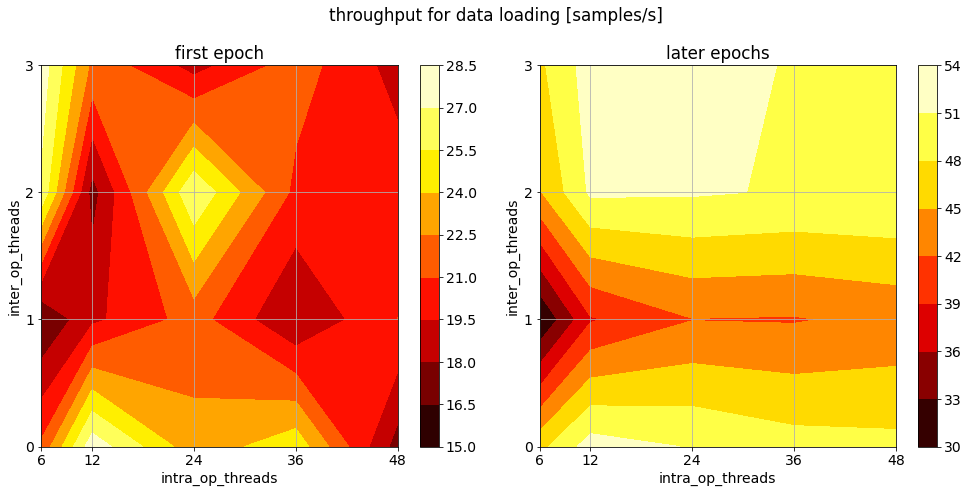

In [14]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, figsize=(14,7))

ax0.set_title('first epoch')
image = results[['inter_threads','intra_threads','total_throughput_mean_init']].to_numpy().reshape((len(inter_threads), len(intra_threads), 3))[:,:,2]
pos = ax0.contourf( intra_threads, inter_threads, image,cmap='hot')
ax0.set_ylabel('inter_op_threads')
ax0.set_yticks(inter_threads)
ax0.set_xlabel('intra_op_threads')
ax0.set_xticks(intra_threads)
ax0.grid()
fig.colorbar(pos, ax=ax0)

ax1.set_title('later epochs')
image = results[['inter_threads','intra_threads','total_throughput_mean_later']].to_numpy().reshape((len(inter_threads), len(intra_threads), 3))[:,:,2]
pos = ax1.contourf( intra_threads, inter_threads, image,cmap='hot')
ax1.set_ylabel('inter_op_threads')
ax1.set_yticks(inter_threads)
ax1.set_xlabel('intra_op_threads')
ax1.set_xticks(intra_threads)
ax1.grid()
fig.colorbar(pos, ax=ax1)

fig.suptitle('throughput for data loading [samples/s]')

plt.tight_layout()

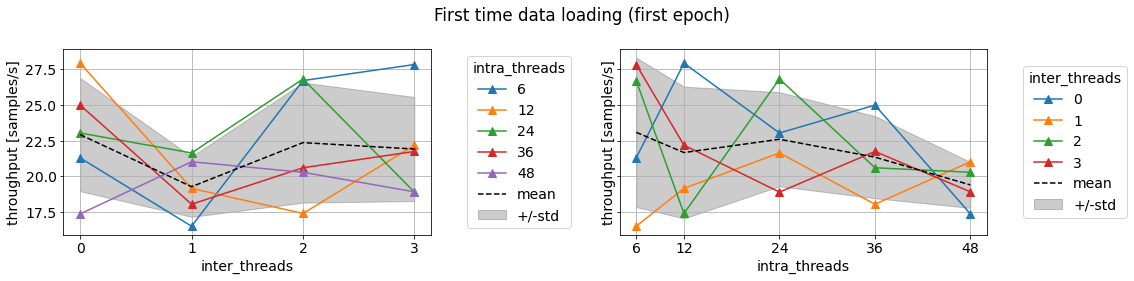

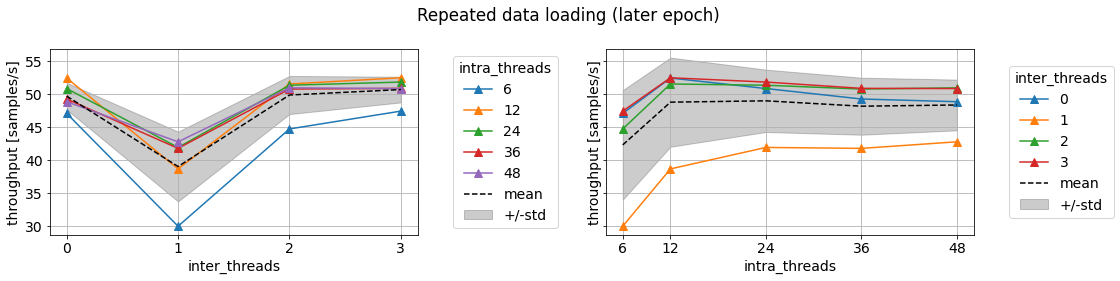

In [15]:
def group_by_plot(ax, group_by_key, x_var, y_var, title=None, x_label=None, y_label=None):
    for key, grp in results.groupby([group_by_key], sort=False):
        ax.plot(grp[x_var], grp[y_var], '^-',  ms=8, label=key)
        
    grouped_by_x = results[[x_var,y_var]].groupby([x_var], sort=False)[y_var]
    grouped_by_x_mean = grouped_by_x.mean()
    grouped_by_x_std = grouped_by_x.std()
    ax.plot(grouped_by_x_mean.reset_index()[x_var], grouped_by_x_mean, '--',  ms=8, label='mean', color='black')
    ax.fill_between(grouped_by_x_std.reset_index()[x_var], grouped_by_x_mean - grouped_by_x_std, grouped_by_x_mean + grouped_by_x_std, alpha=0.2, color='black', label='+/-std')

    
    ax.set_xticks(grp[x_var])
    ax.set_xlabel(x_var if x_label is None else x_label)
    ax.set_ylabel(y_var if y_label is None else y_label)

    ax.legend(title=group_by_key, loc='center right', bbox_to_anchor=(1.4, 0.5))
    ax.grid()
    if title is not None:
        ax.set_title(title)

        
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,4))

fig.suptitle('First time data loading (first epoch)')

group_by_plot(axs[0], 'intra_threads', 'inter_threads', 'total_throughput_mean_init', y_label='throughput [samples/s]')
group_by_plot(axs[1], 'inter_threads', 'intra_threads', 'total_throughput_mean_init', y_label='throughput [samples/s]')

fig.tight_layout()

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,4))

fig.suptitle('Repeated data loading (later epoch)')

group_by_plot(axs[0], 'intra_threads', 'inter_threads', 'total_throughput_mean_later', y_label='throughput [samples/s]')
group_by_plot(axs[1], 'inter_threads', 'intra_threads', 'total_throughput_mean_later', y_label='throughput [samples/s]')

fig.tight_layout()
plt.show()

## Discussion

(CPU specification see below)

- `inter_threads` (left column): Setting this to 1 (number of sockets) generally leads to worse performance than leaving it at 0. For `intra_threads` in {12, 24}, the best performance is obtained at `inter_threads` = 0, although, higher values should be tested.
- `intra_threads` (right column): The first epoch shows that `intra_threads` should be set to no more than the max. number of running threads (24), whereas the repeated data loading measurements demonstrate that also should not be smaller than the core number (12) on the machine.

The heatmaps suggest that the configurations (12,0) and (24,2) may yield optimal performance.

To confirm this, the measurement should be repeated, guaranteeing exclusive access to the data during for each benchmark process. Also, a comparison to an actual training loop would make sense.

This topic has also been discussed [here](https://groups.google.com/a/tensorflow.org/d/msg/discuss/UQx7G9Gs7tI/ZYDcbEPkBQAJ).

### GPU-compute node CPU spec

```
> lscpu
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              24
On-line CPU(s) list: 0-23
Thread(s) per core:  2
Core(s) per socket:  12
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping:            2
CPU MHz:             2601.000
CPU max MHz:         2601.0000
CPU min MHz:         1200.0000
BogoMIPS:            5199.99
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            30720K
NUMA node0 CPU(s):   0-23
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm cpuid_fault epb invpcid_single pti intel_ppin ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm xsaveopt cqm_llc cqm_occup_llc dtherm ida arat pln pts md_clear flush_l1d
```